# ALeRCE ZTF Data Stream Test Code

Demonstrate access to the [Automatic Learning for the Rapid Classification of Events](http://alerce.science/) (ALeRCE) data stream. Requires installation of the ALeRCE [Python client](https://github.com/alercebroker/alerce_client), which is accessible in pip.

In [1]:
import requests
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.time import Time

import pandas as pd

from alerce.core import Alerce
from alerce.exceptions import APIError

In [2]:
mpl.rc('font', size=12)

## User entered stuff about the center of the search and DESI observation

In [3]:
ra = 220.
dec = 0.
today = Time.now()
obsmjd = today + 3
mag_cut = 24.5
search_radius = 10 # in degrees

## ALERCE ZTF objects

The client software comes with an API that lets users query objects based on classification algorithm, object type, classification probability, first and last observation MJD, central location and search radius, etc. Unfortunately, as of March 2021 the system is a bit delicate and has trouble handling many of these queries, resulting in an uninformative `APIError` being raised. The function below wraps the client API to avoid these kinds of errors.

In [4]:
alerce_client = Alerce()

In [5]:
def access_alerts(lastmjd=None, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           order_by='oid',
                                           order_mode='ASC',
                                           page_size=1000,
                                           format='pandas')
        
        if lastmjd is not None:
            select = data['lastmjd'] >= lastmjd
            data = data[select]
            
        dataframes.append(data)
    
    return pd.concat(dataframes).sort_values(by='lastmjd')

### Access Alerts from the Past Month

By default, this will use the `stamp_classifier` from ZTF.

By default, it also searches for `SN` and `AGN` alert types.

In [6]:
alerts = access_alerts(lastmjd=today.mjd-28)
alerts

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
446,ZTF18aaaaudp,178,781,58129.268414,59278.140197,True,True,144,0.117286,0.079982,...,59278.140197,815.847141,62.190787,34.094002,0.000053,0.000034,SN,stamp_classifier,0.326887,correction_0.0.1
635,ZTF17aaaebov,30,1295,58101.122488,59278.144028,True,True,31,3.512600,2.693999,...,59278.144028,853.774143,66.098660,51.813029,0.000219,0.000072,AGN,stamp_classifier,0.498128,correction_0.0.1
337,ZTF17aaabkxw,299,1158,58096.086562,59278.146007,True,True,155,1.173900,1.205017,...,59278.144028,900.651157,67.997838,51.841502,0.000083,0.000060,AGN,stamp_classifier,0.445811,correction_0.0.1
499,ZTF17aaacjqz,87,1067,58069.420521,59278.155498,True,True,50,0.901207,1.348829,...,59278.155498,903.649525,81.404222,23.782356,0.000054,0.000049,AGN,stamp_classifier,0.511732,correction_0.0.1
42,ZTF17aaaebyo,47,1372,58101.121944,59278.157963,True,False,16,0.609428,0.714817,...,59278.157963,767.002130,61.114904,55.520152,0.000068,0.000044,SN,stamp_classifier,0.794513,correction_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,ZTF17aaawgek,734,1121,58095.075336,59302.490463,True,True,292,2.841085,2.848290,...,59305.503901,982.078391,302.603407,44.941694,0.000068,0.000028,SN,stamp_classifier,0.351264,correction_0.0.1
675,ZTF17aaaeiuy,186,3251,58101.141065,59302.524479,True,True,81,1.295500,0.841933,...,59305.517153,254.124884,327.495941,29.421488,0.000096,0.000081,AGN,stamp_classifier,0.397735,correction_0.0.1
601,ZTF17aaadozi,141,617,58280.379954,59305.518113,True,True,67,0.515506,0.740407,...,59305.518113,931.251030,320.727049,2.061509,0.000067,0.000071,AGN,stamp_classifier,0.401631,correction_0.0.1
283,ZTF17aabuuor,796,1445,58095.138275,59302.522963,True,False,462,0.847800,0.885117,...,59305.518727,959.175023,343.097407,48.282884,0.000071,0.000064,SN,stamp_classifier,0.563163,correction_0.0.1


### Plot Alerts

This function wraps the matplotlib Mollweide projection and returns alert positions on the sky.

In [7]:
def plot_radec(dataframe):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(dataframe['class'])
    for class_name in class_names:
        select = dataframe['class'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(dataframe[select]['meanra'].apply(lambda x: 180 - x))
        _dec = np.radians(dataframe[select]['meandec'])
        ax.scatter(_ra, _dec, alpha=0.5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8)
    fig.tight_layout()

    return fig;

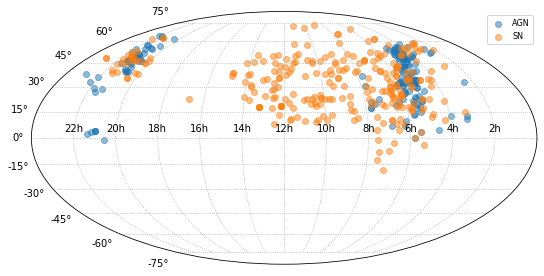

In [8]:
fig = plot_radec(alerts)

### Access Alerts from the Past Month

Try running the `lc_classifier` (requires >6 observations to estimate the light curve) and search for supernovae observed within the past 4 weeks.

In [9]:
lc_alerts = access_alerts(lastmjd=today.mjd-28, classifier='lc_classifier', class_names=['SNIa', 'SNIbc', 'SNII', 'SLSN'])
lc_alerts

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
250,ZTF19aagwzod,241,630,58514.126574,59278.137836,True,False,135,0.143652,0.587158,...,59278.137836,764.011261,67.161589,-0.011103,0.000077,0.000050,SLSN,lc_classifier,0.161604,correction_0.0.1
932,ZTF20accwlaq,36,649,59108.464572,59278.139248,False,False,25,1.757010,NaN,...,59278.139248,169.674676,66.736373,14.498512,0.000164,0.000076,SNII,lc_classifier,0.163080,correction_0.0.1
163,ZTF18achscsb,89,667,58434.369919,59278.148866,True,True,45,0.909100,1.031899,...,59278.148866,472.676736,96.336930,-13.339877,0.000107,0.000126,SLSN,lc_classifier,0.135720,correction_0.0.1
119,ZTF18abzigax,127,585,58207.134317,59278.154086,True,False,64,-0.270400,0.411010,...,59278.154086,171.652338,80.268436,3.554823,0.000080,0.000065,SLSN,lc_classifier,0.234220,correction_0.0.1
1,ZTF17aaaebyo,47,1372,58101.121944,59278.157963,True,False,16,0.609428,0.714817,...,59278.157963,767.002130,61.114904,55.520152,0.000068,0.000044,SNIbc,lc_classifier,0.176220,correction_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,ZTF18abesiyg,305,1469,58291.436852,59305.502951,False,False,201,0.944600,0.696426,...,59305.502951,1014.066099,303.841612,30.058292,0.000203,0.000076,SNIbc,lc_classifier,0.130968,correction_0.0.1
312,ZTF19aaucpzi,410,1295,58383.221319,59305.503426,True,True,190,2.111336,1.557558,...,59305.503426,716.075405,315.650191,37.551124,0.000098,0.000039,SNII,lc_classifier,0.179124,correction_0.0.1
479,ZTF19acarjgl,49,1041,58372.276655,59305.514178,True,True,27,0.436760,0.692726,...,59305.514178,555.321088,326.979547,33.896736,0.000147,0.000111,SNII,lc_classifier,0.124800,correction_0.0.1
23,ZTF17aabvdgb,119,1283,58286.342581,59305.517153,True,True,45,0.699091,1.420695,...,59305.517153,1018.074225,319.672328,29.828841,0.000207,0.000116,SNIbc,lc_classifier,0.154128,correction_0.0.1


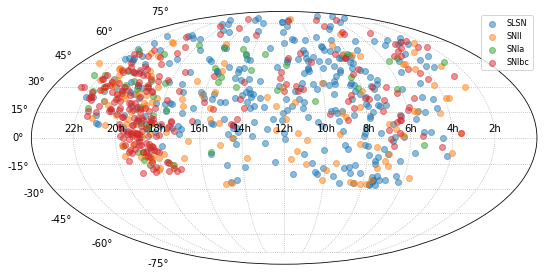

In [10]:
fig = plot_radec(lc_alerts)

#### Common Alerts between Classifiers

Plot events in common between the `stamp_classifier` and the `lc_classifier`.

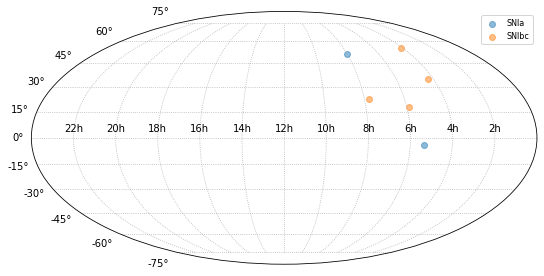

In [11]:
select = lc_alerts['oid'].isin(alerts['oid'])
fig = plot_radec(lc_alerts[select])

## Forecast Alert Magnitude and Create a ToO Ledger

Use the analytic supernova models available from [Villar et al. 2019](https://arxiv.org/abs/1905.07422) and [Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311).

For the AGN alerts this model will not be useful.

In [26]:
epoch = 2000.0

for index, da in alerts.iterrows():
    query = 'http://3.238.105.175:8081/parametric/sn?oid=%s&mjd=%s' % (da['oid'], obsmjd.mjd)
#     print(query)
    response = requests.get(query)
    forecast = response.json()['forecast']
    
    magpsf = forecast[1]['magpsf']
    if magpsf is not None:
        if forecast[1]['magpsf'] <= mag_cut:
            prog = 'BRIGHT' if forecast[1]['magpsf'] < 21 else 'DARK'
            print('{:<10.6f} {:>10.6f} {:>9.6f} {:>9.6f} {:>7.1f}    FIBER  {:7s} {:>15.8f} {:>15.8f}'.format(
                da['meanra'], da['meandec'], 0, 0, epoch, prog, da['lastmjd'], obsmjd.mjd+14))

60.356080   51.905202  0.000000  0.000000  2000.0    FIBER  BRIGHT   59278.15796300  59322.93196558
60.947423   21.563753  0.000000  0.000000  2000.0    FIBER  DARK     59278.19918980  59322.93196558
150.887307  71.147401  0.000000  0.000000  2000.0    FIBER  BRIGHT   59278.24723380  59322.93196558
84.273955   21.636950  0.000000  0.000000  2000.0    FIBER  DARK     59280.18677080  59322.93196558
132.950501  30.385338  0.000000  0.000000  2000.0    FIBER  DARK     59280.25618060  59322.93196558
120.648992  50.922544  0.000000  0.000000  2000.0    FIBER  DARK     59280.25951390  59322.93196558
194.773926  24.442532  0.000000  0.000000  2000.0    FIBER  DARK     59280.37309030  59322.93196558
116.229640  22.565957  0.000000  0.000000  2000.0    FIBER  BRIGHT   59281.22479170  59322.93196558
59.403393   12.408657  0.000000  0.000000  2000.0    FIBER  DARK     59290.18743060  59322.93196558
136.529358  23.458555  0.000000  0.000000  2000.0    FIBER  BRIGHT   59290.23491900  59322.93196558
